# Preprocess

In [57]:
import os
import cv2
import random

from tqdm import tqdm

import skimage
import PIL.Image as Image

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from IPython.display import display

voc_folder = '/home/data1/ruofan/VOCdevkit/VOC2012'
voc_img_folder = os.path.join(voc_folder, 'JPEGImages')
voc_anno_folder = os.path.join(voc_folder, 'Annotation')
voc_segobj_folder = os.path.join(voc_folder, 'SegmentationObject')
voc_segclass_folder = os.path.join(voc_folder, 'SegmentationClass')
voc_seg_folder = os.path.join(voc_folder, 'SegmentationClass')

## Take a look of the images

***Note: different `imread` methods has different channel order***

- PIL.Image.open  # RGB
- skimage.io.imread  # RGB
- matplot.image.imread  # RGB
- cv2.imread  # BGR

(500, 347, 3)


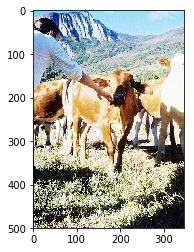

In [26]:
img = mpimg.imread('/home/data1/ruofan/VOCdevkit/VOC2012/JPEGImages/2010_003239.jpg')
plt.imshow(img)
print(img.shape)

/home/data1/ruofan/VOCdevkit/VOC2012/SegmentationObject/2010_003239.png


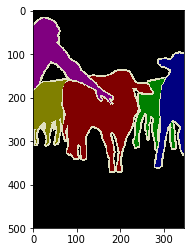

In [69]:
for root, dirs, files in os.walk(voc_segobj_folder):
    file = files[1953]
    path = os.path.join(root, file)
    print(path)
    img = mpimg.imread(path)
    plt.imshow(img)

/home/data1/ruofan/VOCdevkit/VOC2012/SegmentationClass/2010_003239.png


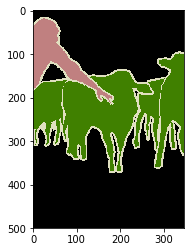

In [70]:
for root, dirs, files in os.walk(voc_segclass_folder):
    file = files[1953]
    path = os.path.join(root, file)
    print(path)
    img = mpimg.imread(path)
    plt.imshow(img)

### What about colors ?

- We have 20 classes, each represented with a kind of color.
- encode(): [r, g, b] -> number between 0 and 20
- decode(): number between 0 and 20 -> [r, g, b]

In [29]:
color_dict = {
    0:[0, 0, 0], 
    1:[128, 0, 0], 
    2:[0, 128, 0], 
    3:[128, 128, 0], 
    4:[0, 0, 128], 
    5:[128, 0, 128],
    6:[0, 128, 128], 
    7:[128, 128, 128], 
    8:[64, 0, 0], 
    9:[192, 0, 0], 
    10:[64, 128, 0],
    11:[192, 128, 0], 
    12:[64, 0, 128], 
    13:[192, 0, 128], 
    14:[64, 128, 128], 
    15:[192, 128, 128],
    16:[0, 64, 0], 
    17:[128, 64, 0], 
    18:[0, 192, 0], 
    19:[128, 192, 0], 
    20:[0, 64, 128],
    21:[224, 224, 195],
}

In [30]:
def rgb2int(rgb):
    r, g, b = rgb
    return (r << 16) + (g << 8) + b

def bgr2int(bgr):
    b, g, r = bgr
    return (r << 16) + (g << 8) + b

In [31]:
print('decode_dict = {')
for c in range(len(color_dict)):
    print(f'    {rgb2int(color_dict[c])}: {c},')
print('}')

decode_dict = {
    0: 0,
    8388608: 1,
    32768: 2,
    8421376: 3,
    128: 4,
    8388736: 5,
    32896: 6,
    8421504: 7,
    4194304: 8,
    12582912: 9,
    4227072: 10,
    12615680: 11,
    4194432: 12,
    12583040: 13,
    4227200: 14,
    12615808: 15,
    16384: 16,
    8404992: 17,
    49152: 18,
    8437760: 19,
    16512: 20,
    14737603: 21,
}


In [44]:
encode_dict = {
    0: 0,
    8388608: 1,
    32768: 2,
    8421376: 3,
    128: 4,
    8388736: 5,
    32896: 6,
    8421504: 7,
    4194304: 8,
    12582912: 9,
    4227072: 10,
    12615680: 11,
    4194432: 12,
    12583040: 13,
    4227200: 14,
    12615808: 15,
    16384: 16,
    8404992: 17,
    49152: 18,
    8437760: 19,
    16512: 20,
    
    14737600: 21,  # edge
}

In [227]:
def encode(bgr):
    return encode_dict[bgr2int(bgr)]

def decode(c):
    return np.array(color_dict[c], dtype=np.int32)

Test

In [72]:
print(encode([0, 192, 128]))
print(decode(19))

19
[128 192   0]


### What about image size?

- They all have different sizes
- Resize them when training

In [35]:
for root, dirs, files in os.walk(voc_img_folder):
    for file in files[:10]:
        path = os.path.join(root, file)
        img = mpimg.imread(path)
        print(f'img:{file}\tshape:{img.shape}')

img:2012_002447.jpg	shape:(375, 500, 3)
img:2009_002615.jpg	shape:(375, 500, 3)
img:2008_005379.jpg	shape:(375, 500, 3)
img:2008_002716.jpg	shape:(375, 500, 3)
img:2012_004285.jpg	shape:(319, 500, 3)
img:2008_000189.jpg	shape:(333, 500, 3)
img:2011_004727.jpg	shape:(500, 375, 3)
img:2009_001260.jpg	shape:(375, 500, 3)
img:2008_005404.jpg	shape:(375, 500, 3)
img:2012_003336.jpg	shape:(500, 357, 3)


## Generate train.txt, test.txt, val.txt

### The number of segmentation samples are not the same with that of the original images

In [12]:
for root, dirs, files in os.walk(voc_img_folder):
    img_files = sorted(files)
    print(f'There are {len(files)} images in {root}')
    
for root, dirs, files in os.walk(voc_segclass_folder):
    seg_files = sorted(files)
    print(f'There are {len(files)} images in {root}')
    
for root, dirs, files in os.walk(voc_segobj_folder):
    seg_files = sorted(files)
    print(f'There are {len(files)} images in {root}')
    
# for img, seg in zip(img_files, seg_files):
#     print(f'img:{img}\tseg:{seg}')

There are 17125 images in /home/data1/ruofan/VOCdevkit/VOC2012/JPEGImages
There are 2913 images in /home/data1/ruofan/VOCdevkit/VOC2012/SegmentationClass
There are 2913 images in /home/data1/ruofan/VOCdevkit/VOC2012/SegmentationObject


### Seperate dataset into training set and testing set

In [13]:
random.seed(1953)
train = []
test = []

for root, dirs, files in os.walk(voc_segclass_folder):
    for file in files:
        if random.random() < 0.8:
            train.append(os.path.splitext(file)[0])
        else:
            test.append(os.path.splitext(file)[0])

print(f'{len(train)} samples for training')
print(f'{len(test)} samples for testing')

2328 samples for training
585 samples for testing


In [14]:
with open('../train.txt', 'w') as f:
    for file in tqdm(train):
        x = os.path.join(voc_img_folder, f'{file}.jpg')
        y = os.path.join(voc_seg_folder, f'{file}.png')

        assert os.path.exists(x), x
        assert os.path.exists(y), y
        
        image_raw = cv2.imread(x)
        label_raw = cv2.imread(y)
        
        h, w = label_raw.shape[:2]
        label = np.zeros((h, w, 1))
        for i in range(h):
            for j in range(w):
                label[i, j, 0] = encode(label_raw[i, j])
                
        label = cv2.resize(label, (240, 240), interpolation=cv2.INTER_NEAREST)
        image = cv2.resize(image_raw, (240, 240), interpolation=cv2.INTER_NEAREST)
        
        x = f'../train/{file}.jpg'
        y = f'../train/{file}.png'
        
        cv2.imwrite(x, image)
        cv2.imwrite(y, label)
        
        f.write(f'{x} {y}\n')

100%|██████████| 2328/2328 [1:10:52<00:00,  1.61s/it]


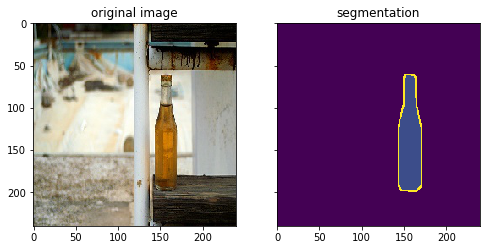

In [15]:
with open('../train.txt') as f:
    image_path, label_path = f.readline().split()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex='all', sharey='all')
    ax1.imshow(mpimg.imread(image_path))
    ax1.set_title('original image')
    ax2.imshow(mpimg.imread(label_path))
    ax2.set_title('segmentation')

In [18]:
with open('../test.txt', 'w') as f:
    for file in tqdm(test):
        x = os.path.join(voc_img_folder, f'{file}.jpg')
        y = os.path.join(voc_seg_folder, f'{file}.png')
        
        assert os.path.exists(x), x
        assert os.path.exists(y), y
        
        image_raw = cv2.imread(x)
        label_raw = cv2.imread(y)
        
        h, w = label_raw.shape[:2]
        label = np.zeros((h, w, 1))
        for i in range(h):
            for j in range(w):
                label[i, j, 0] = encode(label_raw[i, j])
                
        label = cv2.resize(label, (240, 240), interpolation=cv2.INTER_NEAREST)
        image = cv2.resize(image_raw, (240, 240), interpolation=cv2.INTER_NEAREST)
        
        x = f'../test/{file}.jpg'
        y = f'../test/{file}.png'
        
        cv2.imwrite(x, image)
        cv2.imwrite(y, label)
        
        f.write(f'{x} {y}\n')

100%|██████████| 585/585 [16:03<00:00,  1.71s/it]


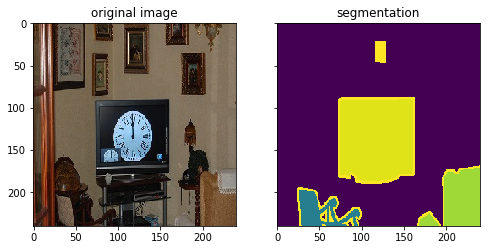

In [97]:
with open('../test.txt') as f:
    image_path, label_path = f.readline().split()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex='all', sharey='all')
    ax1.imshow(mpimg.imread(image_path))
    ax1.set_title('original image')
    ax2.imshow(mpimg.imread(label_path))
    ax2.set_title('segmentation')

In [95]:
def colors(image):
    color_list = {0:(0, 0, 0)}
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            b, g, r = image[i][j]
            code = (int(r)<<16) + (int(g)<<8) + int(b)
            if code not in color_list.keys():
                color_list[code] = (r, g, b)
    
    return color_list.values()

In [201]:
ls ../logs/segmentation2/

2007_000039.bmp  2008_001610.bmp  2009_001615.bmp  2010_005705.bmp
2007_000063.bmp  2008_001643.bmp  2009_001802.bmp  2010_005820.bmp
2007_001377.bmp  2008_003480.bmp  2009_001937.bmp  2010_005899.bmp
2007_001717.bmp  2008_003729.bmp  2009_003043.bmp  2011_000345.bmp
2007_003541.bmp  2008_004321.bmp  2009_004409.bmp  2011_001530.bmp
2007_003876.bmp  2008_004399.bmp  2009_004581.bmp  2011_001765.bmp
2007_006444.bmp  2008_005698.bmp  2009_004730.bmp  2011_002027.bmp
2007_007624.bmp  2008_005926.bmp  2009_004882.bmp  2011_002300.bmp
2007_008403.bmp  2008_006229.bmp  2010_000216.bmp  2011_002381.bmp
2007_009597.bmp  2008_006835.bmp  2010_000285.bmp  2011_002770.bmp
2008_000103.bmp  2008_008421.bmp  2010_000675.bmp  2011_003011.bmp
2008_000365.bmp  2008_008773.bmp  2010_001292.bmp  2011_003184.bmp
2008_000567.bmp  2009_000444.bmp  2010_002815.bmp
2008_001030.bmp  2009_000712.bmp  2010_003495.bmp
2008_001387.bmp  2009_000732.bmp  2010_004320.bmp


2007_002597.bmp
2008_000469.bmp
2010_002422.bmp
2010_005725.bmp
2009_000385.bmp
2011_002200.bmp
2011_001276.bmp
2007_008430.bmp
2007_005264.bmp
2010_005021.bmp
2008_000544.bmp
2010_005718.bmp
2009_001744.bmp
2009_000418.bmp
2009_002549.bmp
2007_009597.bmp
2009_005262.bmp
2010_001457.bmp
2011_002504.bmp
2010_002937.bmp
2010_004219.bmp
2010_003956.bmp
2011_001341.bmp
2008_003821.bmp
2007_009759.bmp
2007_000847.bmp
2010_001174.bmp
2008_003814.bmp
2009_002618.bmp
2009_004464.bmp
2009_004805.bmp
2010_000874.bmp
2011_003057.bmp
2011_003141.bmp
2011_000066.bmp
2011_002770.bmp
2011_000661.bmp
2011_000479.bmp
2010_005063.bmp
2008_002936.bmp
2009_001765.bmp
2010_002546.bmp
2010_002531.bmp
2011_003216.bmp
2009_004497.bmp
2011_000068.bmp
2007_009687.bmp
2009_003971.bmp
2007_007048.bmp
2009_003105.bmp
2008_000399.bmp
2011_002124.bmp
2008_004892.bmp
2010_004109.bmp
2009_003043.bmp
2010_005805.bmp
2010_001773.bmp
2008_008301.bmp
2010_005898.bmp
2009_004125.bmp
2007_000676.bmp
2009_001253.bmp
2007_008

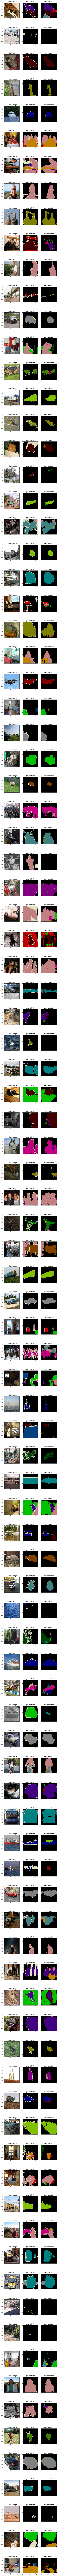

In [258]:
num = 100
fig, ax = plt.subplots(num, 3, figsize=(8, 4*num), sharex='all', sharey='all')

for root, dirs, files in os.walk('../logs/segmentation2'):
    for i, file in enumerate(files[:num]):
        name, ext = os.path.splitext(file)
        print(file)
        
        pred_path = f'{root}/{name}.bmp'
        label_path = f'../train/{name}.png'
        image_path = f'../train/{name}.jpg'

        ax[i, 0].imshow(mpimg.imread(image_path))
        ax[i, 0].set_title('original image')
        ax[i, 1].imshow(decode_img(cv2.imread(label_path, 0)))
        ax[i, 1].set_title('ground truth')
        ax[i, 2].imshow(decode_img(cv2.imread(pred_path, 0)))
        ax[i, 2].set_title('segmentation')

In [250]:
ax

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f660aeb1eb8>,
      dtype=object)

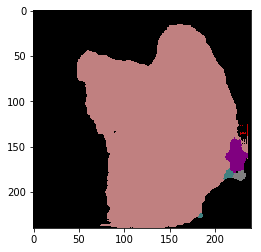

In [233]:
def decode_img(img):
    flatten = []
    image = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.int32)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            p = int(img[i][j])
            flatten.append(p)
            image[i, j, :] = decode(p)
    return image

plt.imshow(decode_img(cv2.imread(f'../logs/segmentation2/{name}.bmp', 0)))